# Projektarbeit 3 - Multilateration mit Monte-Carlo-Simulationen
## Mathematische Modellbildung und Simulation komplexer Systeme
### Maximilian Nowak (DC), Cornelius Rottmair (DC), Tarek Gazzah (DC)
### Arbeitsgruppe 06, SS23, 04.07.2023

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec


from scipy.optimize import least_squares,minimize


from sinfo import sinfo
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
matplotlib  3.7.1
numpy       1.23.5
scipy       1.10.1
sinfo       0.3.4
-----
IPython             8.12.0
jupyter_client      8.1.0
jupyter_core        5.3.0
jupyterlab          3.5.3
notebook            6.5.4
-----
Python 3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19045-SP0
8 logical CPU cores, Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
-----
Session information updated at 2023-07-02 16:35


#### Jupyter notebook Konfiguration

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

### 3.2 Multilateration mit gegebener Geometrie

#### Methoden zum Generieren der Geometrie

In [3]:
def generate_circle_grid(radius, step_size):
    # Define the bounds of the grid based on the radius of the circle
    x = np.arange(-radius, radius + step_size, step_size)
    y = np.arange(-radius, radius + step_size, step_size)

    # Create a grid of points
    x_coords, y_coords = np.meshgrid(x, y)

    circle_points = []
    angle_max = np.pi*(5/4)
    angle_min = np.pi
    
    # Check for each point if it lies within the circle and within the desired angles
    for i in range(x_coords.shape[0]):
        for j in range(y_coords.shape[1]):
            
            if x_coords[i, j]**2 + y_coords[i, j]**2 < radius**2:
                # Convert point to polar coordinates
                r = np.sqrt(x_coords[i, j]**2 + y_coords[i, j]**2)
                theta = np.arctan2(y_coords[i, j], x_coords[i, j])
                
                # Make sure theta is in range [0, 2pi]
                if theta < 0:
                    theta = theta + 2 * np.pi

                # Check if the angle lies within the desired range
                if theta < angle_min or theta > angle_max:
                    circle_points.append((x_coords[i, j], y_coords[i, j]))
    
    return np.array(circle_points)

def get_wall_patches(radius, sector_angles):
    # angles of sector in the circle geometry
    theta1, theta2 = np.rad2deg(sector_angles)
    R = radius

    # Creating two arcs to represent the circle segments
    arc1 = patches.Arc((0,0), 2*R, 2*R, theta1=theta2, theta2=360, edgecolor='#222', linewidth=2)
    arc2 = patches.Arc((0,0), 2*R, 2*R, theta1=0, theta2=theta1, edgecolor='#222', linewidth=2)

    # Creating two lines to represent the sides of the cut out section
    line1 = patches.ConnectionPatch((0,0), (R*np.cos(np.deg2rad(theta1)), R*np.sin(np.deg2rad(theta1))), 'data', 'data', edgecolor='#222', linewidth=2)
    line2 = patches.ConnectionPatch((0,0), (R*np.cos(np.deg2rad(theta2)), R*np.sin(np.deg2rad(theta2))), 'data', 'data', edgecolor='#222', linewidth=2)

    return [arc1, arc2, line1, line2]

#### Methoden für die Simulation der Multilaterion

In [91]:
def squared_loss(params, *args):
    x, y = params
    anchors, meas_dist, sigmas = np.array(args[0]),  np.array(args[1]), np.array(args[2])
    sigma_weigthed = True if len(args)==4 and args[3] else False

    # estimate true distance between anchor and object location
    estim_dist = np.array([np.sqrt((x - anchors[i, 0])**2 + (y - anchors[i, 1])**2) for i in range(anchors.shape[0])])
    
    # compute squared difference between estimated and measured distance
    if sigma_weigthed:
        diff_sq = np.array([(estim_dist[i] - meas_dist[i])**2 / (1 + sigmas[i](meas_dist)**2) for i in range(anchors.shape[0])])
    else:
        diff_sq = np.array([(estim_dist[i] - meas_dist[i])**2  for i in range(anchors.shape[0])])
        
    return np.sum(diff_sq)

def find_best_init_val(r_meas, anchor_visible, R):
    return [0,0]

def find_intersections(anchor_visible, sigmas_visible, anchor_data, R):
    intercepts = []
    init_val = [0, 0]  # Initial guess for the center coordinates
    anchor_data, anchor_visible, sigmas_visible = np.array(anchor_data), np.array(anchor_visible), np.array(sigmas_visible)

    for i in range(anchor_data.shape[1]):
        r_meas_i = anchor_data[:, i]   # get i-th measurement of each anchor
        init_val = find_best_init_val(r_meas_i, anchor_visible, R)
        result = minimize(squared_loss, init_val, method='L-BFGS-B', args=(anchor_visible, anchor_data[:, i], sigmas_visible))
        center_x, center_y = result.x
        intercepts.append([center_x, center_y])
        
    return intercepts


def simulate_measurements(x_a, y_a, x, y, sigma, L):
    # compute the actual distance from the anchor to the object
    d = np.sqrt((x - x_a)**2 + (y - y_a)**2)
    
    # generate L simulated measurements
    return np.random.normal(d, sigma(d), L)

# performs multilateration by monte-carlo simulating measurements on given area points
# and returns rms values
def run_multilat_sim(X, Y, anchors, sigmas, L=20, R=12000):
    rms_grid = np.zeros(len(X))
    measured_pnts = []
    
    for i in range(len(rms_grid)):
        Xi, Yi = X[i], Y[i]
        # determine angle of grid point with respect to origin
        grid_pnt_angle = np.arctan2(Yi, Xi)
        grid_pnt_angle = np.where(grid_pnt_angle < 0, grid_pnt_angle + 2*np.pi, grid_pnt_angle)
        
        # init data to collect for grid point i
        anchor_visible = []
        sigmas_visible = []
        anchor_data = []
        
        for anchor_idx, (sigma, (x_a, y_a)) in enumerate(zip(sigmas, anchors)):
            # determine angle of anchor and sector lines with respect to origin
            anchor_angle = np.arctan2(y_a, x_a)
            anchor_angle = np.where(anchor_angle < 0, anchor_angle + 2*np.pi, anchor_angle)
            section_start, section_end = np.pi, 5*np.pi/4
            
            if(anchor_angle > np.pi):
                section_start = anchor_angle - np.pi
            else:
                if(anchor_angle > np.pi/4):
                    section_end = anchor_angle + np.pi
                    
            # check if grid point is within visible region and if so, perform measurements
            if (grid_pnt_angle <= section_start) or (grid_pnt_angle >= section_end):
                
                # make L measurements for distance of anchor -> grid point 
                dists_n = simulate_measurements(x_a, y_a, X[i], Y[i], sigma, L)
                
                # store recorded data and sigma function
                anchor_visible.append([x_a, y_a, anchor_idx])
                sigmas_visible.append(sigma)
                anchor_data.append(dists_n)

        # if more than one anchor saw the grid point, try to compute intersections
        if(len(anchor_visible) > 1):
            z = np.array([X[i], Y[i]])            
            z_approx = find_intersections(anchor_visible, sigmas_visible, anchor_data, R)
            rms_grid[i] = np.sqrt(np.mean((z - z_approx)**2))
            measured_pnts.append(z_approx)
        else:
            rms_grid[i] = np.NaN

    return rms_grid, np.array(measured_pnts)

def plot_results(R, L, grid, anchors, rms, rms_95, clouds):
    fig, ax = plt.subplots(1,1, figsize=(7,6))
    print("area pts: %s" % str(grid.shape))
    print("95 %% quantile: %.2f" % rms_95)

    # plot circle elements
    for patch in get_wall_patches(R, (np.pi, np.pi*1.25)):
        ax.add_patch(patch)

    # plot grid
    vir = plt.cm.get_cmap('viridis')                                                           # define colormap
    plt.scatter(grid[np.isnan(rms),0], grid[np.isnan(rms), 1],vmin=0, s=90, color='#dfdfdf')   # not visible points

    # quantiles are plotted seperately to not mess up the color gradient of the relevant points
    plt.scatter(grid[:,0][rms >= rms_95], grid[:, 1][rms >= rms_95], c=rms[rms >= rms_95],     # below 95 quantile
                s=90, vmin=0, vmax=40, cmap=vir.reversed())
    plt.scatter(grid[:,0][rms < rms_95], grid[:, 1][rms < rms_95], c=rms[rms < rms_95],        # above 95 quantile
                s=90, vmin=0, vmax=40, cmap=vir.reversed())

    # plot measurement devices and their respective measurement clouds
    plt.plot(anchors[:, 0], anchors[:, 1], ".", color="red", markersize=18, zorder=2.5)
    for i in range(clouds.shape[0]):
        plt.plot(clouds[i, :,0], clouds[i, :, 1], "r.", markersize=1)

    # set title and axis attributes
    plt.suptitle('Multilateration with %i samples per location' % L)
    plt.title('95 %% Quantile of RMS: %.2f' % rms_95)
    plt.colorbar(label='RMS Error', shrink=0.9)  # colorbar for RMS
    plt.gca().set_aspect('equal', adjustable='box')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([-12000, -6000, 0, 6000, 12000])
    ax.set_yticks([-12000, -6000, 0, 6000, 12000])
    ax.set_xlabel(r"Distance [mm] $(\times 10^{3}$)")
    ax.set_ylabel(r"Distance [mm] $(\times 10^{3}$)")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}'))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}'))
    plt.show()

#### Testlauf mit 2 Messgeräten verstärkten Standardabweichungen

area pts: (4, 2)
95 % quantile: 1174.31


C:\Users\maxim\AppData\Local\Temp\ipykernel_4248\576523715.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  vir = plt.cm.get_cmap('viridis')                                                           # define colormap
C:\Users\maxim\AppData\Local\Temp\ipykernel_4248\576523715.py:104: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(grid[np.isnan(rms),0], grid[np.isnan(rms), 1],vmin=0, s=90, color='#dfdfdf')   # not visible points


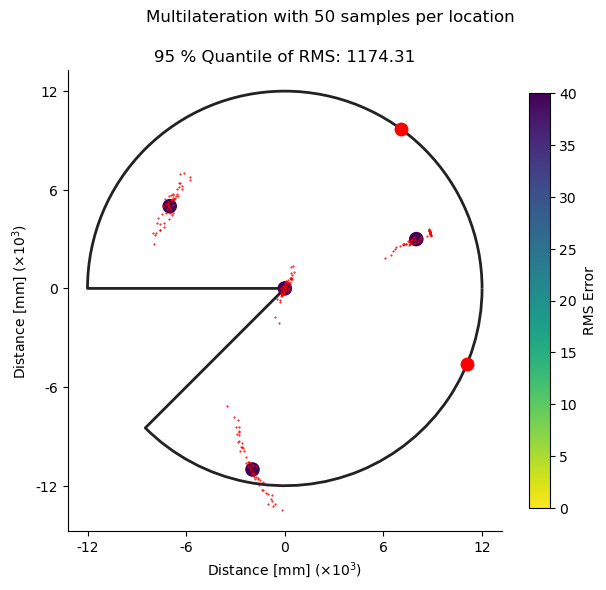

In [95]:
# noise error functions
s1_test = lambda r: 0.2 + 0.05*r
s2_test = lambda r: 1.0 + 0.01*r
sigmas_test = [s1_test, s2_test]

# define simulation parameters
# --------------------------------------
L = 50                                                                  # number of measurements per point
R = 12000                                                               # circle radius
grid = np.array([[0, 0],[8000, 3000], [-2000,-11000], [-7000, 5000]])   # grid points
thetas_guess = [np.pi*0.3, np.pi*-0.125]                                # locations of measurement anchors
anchors = [(R*np.cos(theta), R*np.sin(theta)) for theta in thetas_guess]
anchors = np.array(anchors)

# run simulation
rms, clouds = run_multilat_sim(grid[:, 0], grid[:, 1], anchors, sigmas_test, L=L)
rms_95 = np.quantile(rms, 0.95)

# Plot results
plot_results(R, L, grid, anchors, rms, rms_95, clouds)

#### Selbstkalibrierende Multilaterion mit 3 Messgeräten und 534 Gitterpunkten 

[0.7853981633974483, 0.7853981633974483, 0] 11905.698785568653
[1.0995574287564276, 0.7853981633974483, 0] 10461.737530758908
[1.413716694115407, 0.7853981633974483, 0] 60.43417297203218
[1.413716694115407, 0.0, 0] 24.284492863159116
[1.413716694115407, 0.19634954084936207, 0] 27.37488935149417
[1.413716694115407, 0.39269908169872414, 0] 29.795397125646975
[1.413716694115407, 0.5890486225480862, 0] 40.6018741381302
[1.413716694115407, 0.0, 8000] 120.6290701015835
[1.413716694115407, 0.0, 7000] 43.662433220824866
[1.413716694115407, 0.0, 6000] 42.233777337372025
[1.413716694115407, 0.0, 5000] 27.422222218774486
[1.413716694115407, 0.0, 4000] 28.158698886422474
[1.413716694115407, 0.0, 3000] 26.147009151698338
[1.413716694115407, 0.0, 2000] 30.52340259353999
[[ 1877.21358048 11852.26008714]
 [12000.             0.        ]
 [-2121.32034356 -2121.32034356]]
area pts: (534, 2)
95 % quantile: 26.58


C:\Users\maxim\AppData\Local\Temp\ipykernel_4248\576523715.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  vir = plt.cm.get_cmap('viridis')                                                           # define colormap
C:\Users\maxim\AppData\Local\Temp\ipykernel_4248\576523715.py:104: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(grid[np.isnan(rms),0], grid[np.isnan(rms), 1],vmin=0, s=90, color='#dfdfdf')   # not visible points


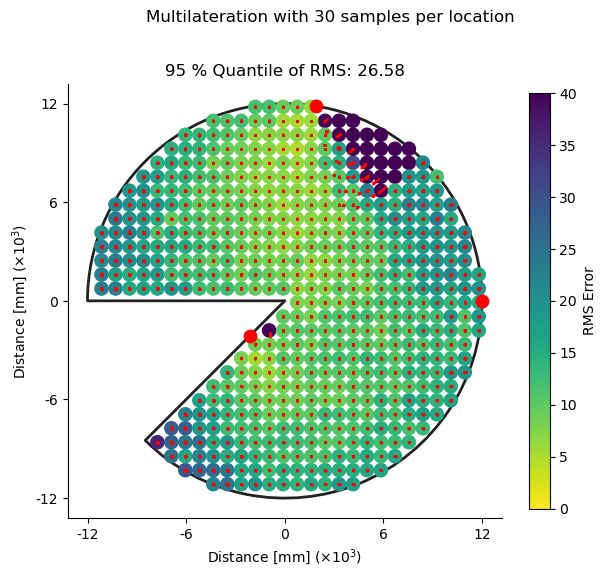

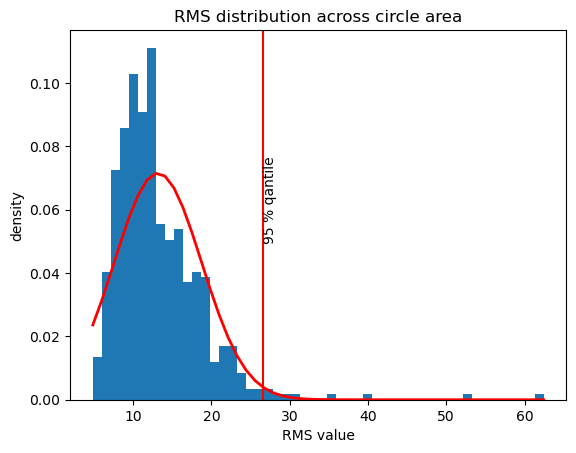

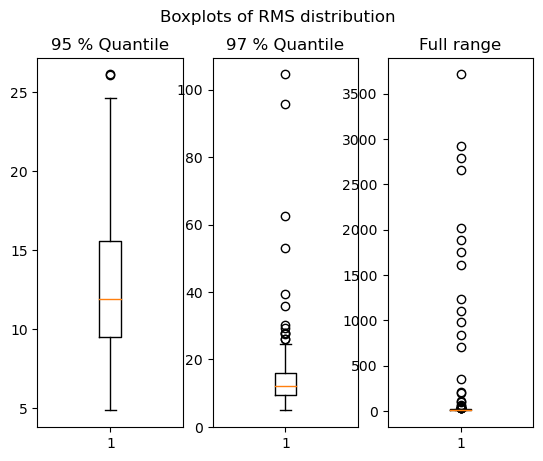

In [96]:
def find_best_init_val(r_meas, anchor_visible, R):
    init_val = [0,0]
    idx_s = np.argsort(r_meas)
    w = np.array([3,1,1])[:len(r_meas)]
    
    # point is visible only to anchor 1 and 2
    if len(anchor_visible) == 2 and 0 in anchor_visible[:, 2] and 1 in anchor_visible[:, 2]:
        
        # case alpha_1: point is close to anchor 1 but far from anchor 2
        if anchor_visible[idx_s][0, 2] == 0 and r_meas[idx_s][1] > np.sqrt(R**2+R**2):
            init_val = [-6000, 6000]
        else:
        # case alpha_2: point is within close range of only anchor 1 and 2
            tmp_anchors = np.vstack([anchor_visible, [0,0,2]])
            init_val = np.array([np.sum(tmp_anchors[:, 0][idx_s]*w) / (np.sum(w)*len(w)), np.sum(tmp_anchors[:, 1][idx_s]*w) / (np.sum(w)*len(w))])
            
    elif len(anchor_visible) == 2 and 1 in anchor_visible[:, 2] and 2 in anchor_visible[:, 2]:
        # case alpha_3: point is visible only to anchor 2 and 3
        init_val = [6000*np.cos(np.pi*1.375), 6000*np.sin(np.pi*1.375)]
    else:
        # case alpha_4a: point is visible to all three but far from anchor 1
        if r_meas[idx_s][2] > np.sqrt(R**2+R**2):
            init_val = [6000, -6000]
        else:
        # case alpha_4b: point is visible to all anchors and within medium range
            init_val = np.array([np.sum(anchor_visible[:, 0][idx_s]*w) / (np.sum(w)*len(w)), np.sum(anchor_visible[:, 1][idx_s]*w) / (np.sum(w)*len(w))])
            
    return init_val

# loss function to optimize positional attributes of all three anchors
def loss_func(x0, *args):
    theta1, theta2, r = x0
    R, L, grid, sigmas = args
    
    # translate positions to cartesian coordinates
    anchors = [(R*np.cos(theta), R*np.sin(theta)) for theta in [theta1, theta2]]
    anchors.append((r*np.cos(np.pi*1.25), r*np.sin(np.pi*1.25)))

    # determine rms of all grid points with current parameters
    rms, datapoints = run_multilat_sim(grid[:, 0], grid[:, 1], anchors, sigmas, L=L)
    
    # as metric return 95 % quantile of all non NaN values
    return np.quantile(rms[~np.isnan(rms)], 0.95)

# brute force method to find best parameters within given ranges
def tune_hyperparams(x0, args):
    bnds, loss_args = args
    
    # for each parameter run simulations with parameters from the given interval
    for i, (lb, rb, step) in enumerate(bnds):
        rms_i = {}
        for p_val in np.arange(lb, rb, step):
            params = x0
            params[i] = p_val
            rms_i[p_val] = loss_func(params, *loss_args)
            print(params, rms_i[p_val])
        
        # find minimum in dict of results
        min_val = min(rms_i, key=rms_i.get)
        
        # perform simulations for next parameter with new minimum
        x0[i] = min_val
        
    return x0

# noise error functions
s1 = lambda r: 0.2 + 0.001*r
s2 = lambda r: 1.0 + 0.0005*r
s3 = lambda r: 0.5 + 0.002*r
sigmas = [s1, s2, s3]

# tune hyperparams setup
# ---------------------------------
R = 12000
L = 10
grid_opt = generate_circle_grid(12000, 1000)

bnds = [(np.pi*0.25, np.pi*0.5, np.pi*0.1),
        (np.pi*0, np.pi*(4/16), np.pi*(1/16)),
        (8000, 1000, -1000)]

thetas_guess = [np.pi*0.25, 0]
x0 = thetas_guess
x0.insert(0, 8000)

# start optimization 
res_x = tune_hyperparams(x0, args=(bnds, (R, L, grid_opt, sigmas)))
theta1_opt, theta2_opt, r_opt = res_x

# initialize anchor location with optimized locations
anchors = [(R*np.cos(theta), R*np.sin(theta)) for theta in [theta1_opt, theta2_opt]]
anchors.append((r_opt*np.cos(np.pi*1.25), r_opt*np.sin(np.pi*1.25)))
anchors = np.array(anchors)
print(anchors)

# run simulation with optimized parameters
# --------------------------------------
L = 30
grid = generate_circle_grid(12000, 850)
rms, clouds = run_multilat_sim(grid[:, 0], grid[:, 1], anchors, sigmas, L=L)

# compute 95% quantile of all visibile poitns (:= not NaN)
if len(rms[~np.isnan(rms)]):
    rms_95 = np.quantile(rms[~np.isnan(rms)], 0.95)
else:
    rms_95 = 0


# Plot results
# ----------------------------------------------
plot_results(R, L, grid, anchors, rms, rms_95, clouds)

# histplot for RMS distribution
# --------------------------------------
fig, ax = plt.subplots(1, 1)
count, bins, ignored = ax.hist(rms[rms < rms_95 + 50], bins=50, density=True)
mu = np.mean(rms[rms < rms_95 + 50])
sd = np.std(rms[rms < rms_95 + 50])
ax.plot(bins, 1/(sd * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sd**2) ),
         linewidth=2, color='r')
plt.axvline(x=rms_95, color='r')
plt.text(rms_95, 0.05, '95 % qantile', rotation=90)
plt.title('RMS distribution across circle area')
plt.xlabel('RMS value')
plt.ylabel('density')
plt.show()

# boxplot for RMS distribution
# --------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Boxplots of RMS distribution')
ax1.set_title('95 % Quantile')
ax1.boxplot(rms[rms < rms_95])
ax2.set_title('97 % Quantile')
ax2.boxplot(rms[rms < np.quantile(rms[~np.isnan(rms)], 0.97)])
ax3.set_title('Full range')
ax3.boxplot(rms)
plt.show()

C:\Users\maxim\AppData\Local\Temp\ipykernel_4248\802790619.py:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  ax.scatter(grid[np.isnan(data),0], grid[np.isnan(data), 1],vmin=0, s=30, color='#dfdfdf')


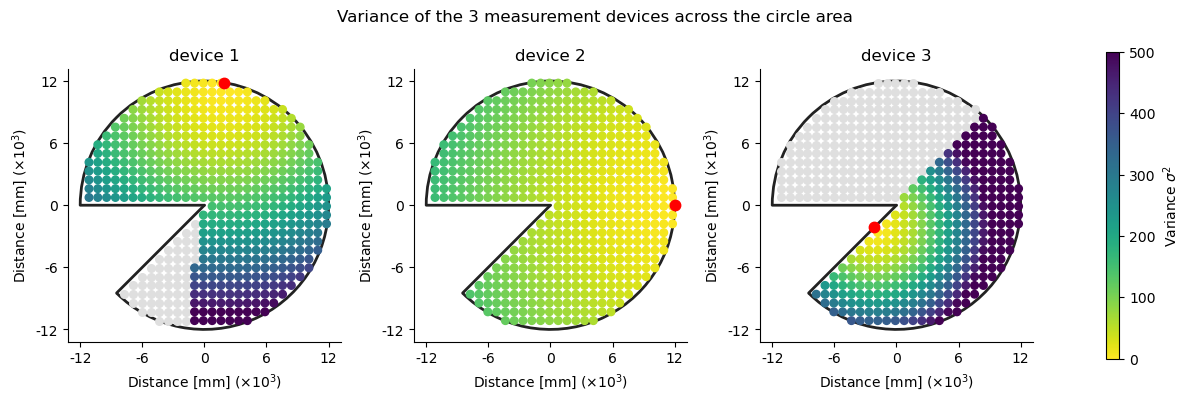

In [97]:
def get_variances(X, Y, anchor, sigma):
    variances = np.zeros(len(X))
    for i in range(len(variances)):
        
        # determine angle of grid point
        g_angle = np.arctan2(Y[i], X[i])
        g_angle = np.where(g_angle < 0, g_angle + 2*np.pi, g_angle)

        x_a, y_a = tuple(anchor)
        angle_i = np.arctan2(y_a, x_a)
        angle_i = np.where(angle_i < 0, angle_i + 2*np.pi, angle_i)
        section_start, section_end = np.pi, 5*np.pi/4
        if(angle_i > np.pi):
            section_start = angle_i - np.pi
        else:
            if(angle_i > np.pi/4):
                section_end = angle_i + np.pi
                
        # check if grid point is within visible region and if so, perform measurements
        if (g_angle <= section_start) or (g_angle >= section_end):
            # determine distance to current point
            d = np.sqrt((X[i]-anchor[0])**2 + (Y[i]-anchor[1])**2)
            
            # determine variance 
            variances[i] = sigma(d)**2
        else:
            variances[i] = np.NaN
    
    return variances

# Compute variances for each device
# ----------------------------------------------
variances1 = get_variances(grid[:, 0], grid[:, 1], anchors[0], s1)
variances2 = get_variances(grid[:, 0], grid[:, 1], anchors[1], s2)
variances3 = get_variances(grid[:, 0], grid[:, 1], anchors[2], s3)


# Plot results
# ----------------------------------------------

fig = plt.figure(figsize=(12, 4))  # Adjust figsize as needed

fig.suptitle(r'Variance of the 3 measurement devices across the circle area')
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])     # divide figure into 4 columns, with last one colorbar
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]  # create subplots in the first 3 columns
cbar_ax = fig.add_subplot(gs[0, 3])                   # create a subplot for the colorbar in the last column

for i, data in enumerate([variances1, variances2, variances3]):
    ax = axes[i]
    
    # plot circle elements
    for patch in get_wall_patches(R, (np.pi, np.pi*1.25)):
        ax.add_patch(patch)

    # plot variance of grid points
    ax.scatter(grid[np.isnan(data),0], grid[np.isnan(data), 1],vmin=0, s=30, color='#dfdfdf')
    scatter = ax.scatter(grid[:, 0], grid[:, 1], c=data, s=30, vmin=0, vmax=500, cmap='viridis_r')
    ax.plot(anchors[i, 0], anchors[i, 1], ".", color="red", markersize=15, zorder=2.5)

    # set title and axis configuration
    ax.set_title('device %s' % str(i+1))
    ax.set_aspect('equal', adjustable='box')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([-12000, -6000, 0, 6000, 12000])
    ax.set_yticks([-12000, -6000, 0, 6000, 12000])
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel(r"Distance [mm] $(\times 10^{3}$)")
    ax.set_ylabel(r"Distance [mm] $(\times 10^{3}$)")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}'))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}'))

# Create a colorbar
cbar = plt.colorbar(scatter, cax=cbar_ax, label=r'Variance $\sigma^2$')

plt.tight_layout()
plt.show()

### Demonstration von schlechten Mess-Setups

#### Beispiel 1: Messgeräte entlang des Kreissegments

area pts: (534, 2)
95 % quantile: 72.31


C:\Users\maxim\AppData\Local\Temp\ipykernel_4248\576523715.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  vir = plt.cm.get_cmap('viridis')                                                           # define colormap
C:\Users\maxim\AppData\Local\Temp\ipykernel_4248\576523715.py:104: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(grid[np.isnan(rms),0], grid[np.isnan(rms), 1],vmin=0, s=90, color='#dfdfdf')   # not visible points


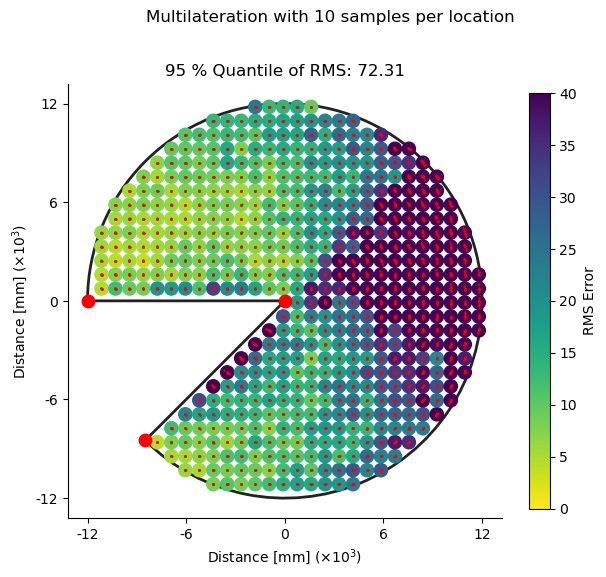

In [98]:
# overwrite method of setting initial values for finding intersections
def find_best_init_val(r_meas, anchor_visible, R):
    init_val = [0,0]
    if len(anchor_visible) == 2 and 0 in anchor_visible[:, 2] and 1 in anchor_visible[:, 2]:
        init_val = [-6000, 6000]
    if len(anchor_visible) == 2 and 1 in anchor_visible[:, 2] and 2 in anchor_visible[:, 2]:
        init_val = [6000, -6000]
        
    return init_val

# noise error functions
s1 = lambda r: 0.2 + 0.001*r
s2 = lambda r: 1.0 + 0.0005*r
s3 = lambda r: 0.5 + 0.002*r
sigmas = [s1, s2, s3]

L = 10
R = 12000
grid = generate_circle_grid(12000, 850)

# simulation 1
# ---------------------------------
anchors = [(-12000, 0)]
anchors.append((0,0))
anchors.append((R*np.cos(np.pi*1.25), R*np.sin(np.pi*1.25)))
anchors = np.array(anchors)

# run simulation
rms, clouds = run_multilat_sim(grid[:, 0], grid[:, 1], anchors, sigmas, L=L)
clouds = np.array(clouds)

if len(rms[~np.isnan(rms)]):
    rms_95 = np.quantile(rms[~np.isnan(rms)], 0.95)
else:
    rms_95 = 0

plot_results(R, L, grid, anchors, rms, rms_95, clouds)



#### Beispiel 2: Messgeräte in den Ecken und entgegengesetzt

area pts: (534, 2)
95 % quantile: 516.90


C:\Users\maxim\AppData\Local\Temp\ipykernel_4248\576523715.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  vir = plt.cm.get_cmap('viridis')                                                           # define colormap
C:\Users\maxim\AppData\Local\Temp\ipykernel_4248\576523715.py:104: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(grid[np.isnan(rms),0], grid[np.isnan(rms), 1],vmin=0, s=90, color='#dfdfdf')   # not visible points


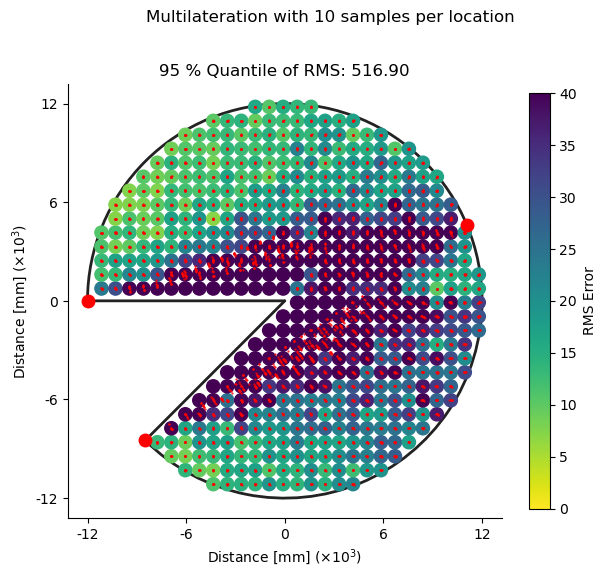

In [99]:
# simulation 2
# ---------------------------------
anchors = [(-12000, 0)]
anchors.append((R*np.cos(np.pi*0.125), R*np.sin(np.pi*0.125)))
anchors.append((R*np.cos(np.pi*1.25), R*np.sin(np.pi*1.25)))
anchors = np.array(anchors)

# run simulation
rms, clouds = run_multilat_sim(grid[:, 0], grid[:, 1], anchors, sigmas, L=L)
clouds = np.array(clouds)

if len(rms[~np.isnan(rms)]):
    rms_95 = np.quantile(rms[~np.isnan(rms)], 0.95)
else:
    rms_95 = 0

plot_results(R, L, grid, anchors, rms, rms_95, clouds)

#### Beispiel 3: Messgeräte nahe beeinander

area pts: (534, 2)
95 % quantile: 86.10


C:\Users\maxim\AppData\Local\Temp\ipykernel_4248\576523715.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  vir = plt.cm.get_cmap('viridis')                                                           # define colormap
C:\Users\maxim\AppData\Local\Temp\ipykernel_4248\576523715.py:104: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(grid[np.isnan(rms),0], grid[np.isnan(rms), 1],vmin=0, s=90, color='#dfdfdf')   # not visible points


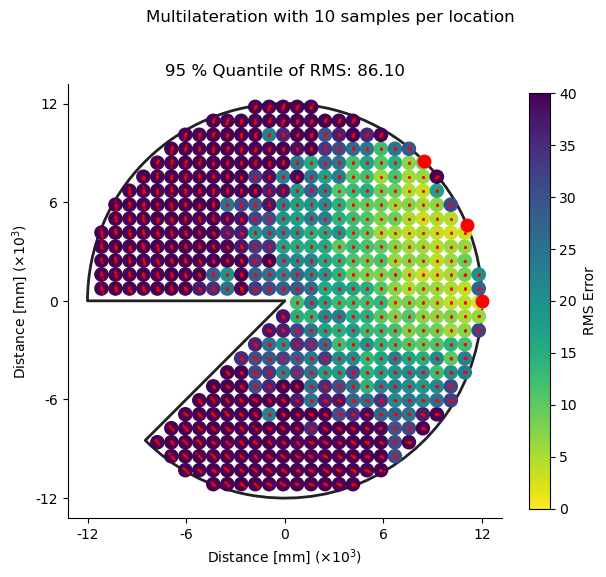

In [100]:
# simulation 3
# ---------------------------------
thetas_guess = [np.pi*0.25, np.pi*0.125, np.pi*0]
anchors = [(R*np.cos(theta), R*np.sin(theta)) for theta in thetas_guess]
anchors = np.array(anchors)

# run simulation
rms, clouds = run_multilat_sim(grid[:, 0], grid[:, 1], anchors, sigmas, L=L)
clouds = np.array(clouds)

if len(rms[~np.isnan(rms)]):
    rms_95 = np.quantile(rms[~np.isnan(rms)], 0.95)
else:
    rms_95 = 0

plot_results(R, L, grid, anchors, rms, rms_95, clouds)

### 3.3 Erweiterung um 4. Abstandsmessgerät

area pts: (534, 2)
95 % quantile: 24.87


C:\Users\maxim\AppData\Local\Temp\ipykernel_4248\576523715.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  vir = plt.cm.get_cmap('viridis')                                                           # define colormap
C:\Users\maxim\AppData\Local\Temp\ipykernel_4248\576523715.py:104: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(grid[np.isnan(rms),0], grid[np.isnan(rms), 1],vmin=0, s=90, color='#dfdfdf')   # not visible points


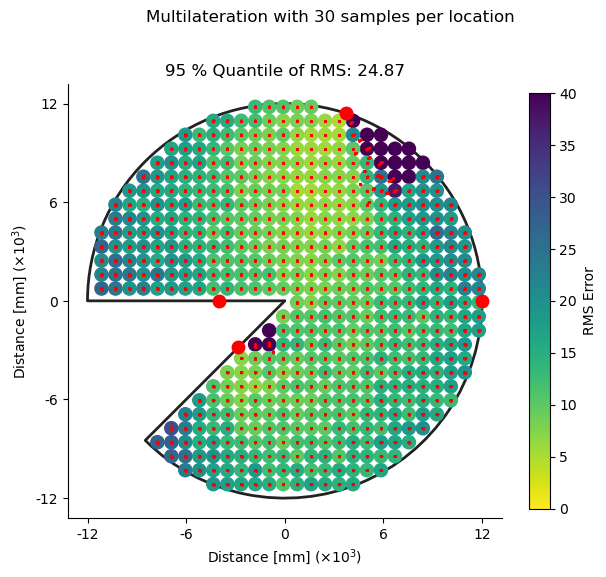

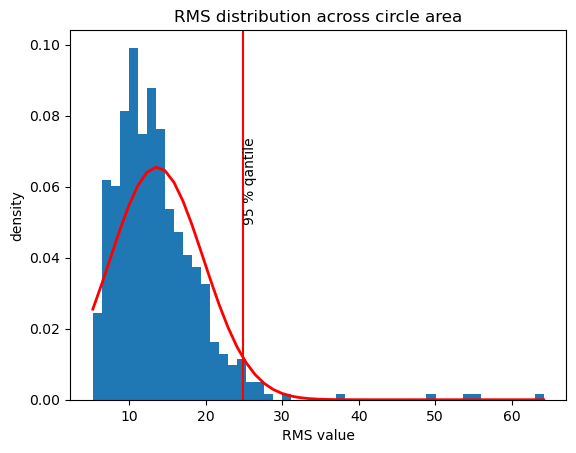

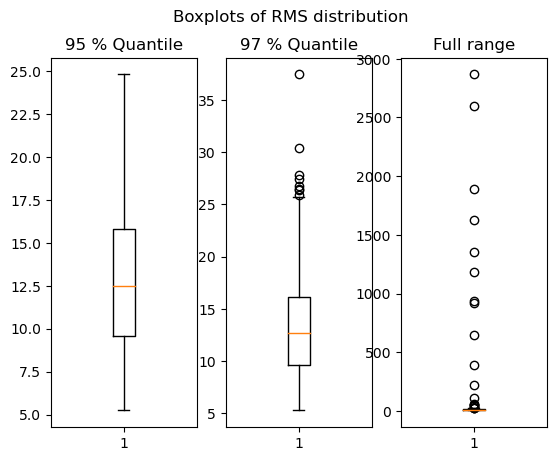

In [94]:
# overwrite method of setting initial values for finding intersections
def find_best_init_val(r_meas, anchor_visible, R):
    init_val = [0,0]

    if len(anchor_visible) == 3 and 0 in anchor_visible[:, 2] and 1 in anchor_visible[:, 2] and 3 in anchor_visible[:, 2]:
        init_val = [-6000, 6000]
    if len(anchor_visible) == 2 and 1 in anchor_visible[:, 2] and 2 in anchor_visible[:, 2]:
        init_val = [0, -6000]
        
    return init_val


# define simulation parameters
# ---------------------------------
L = 30
R = 12000
grid = generate_circle_grid(12000, 850)
thetas_guess = [np.pi*0.4, np.pi*0]
anchors = [(R*np.cos(theta), R*np.sin(theta)) for theta in thetas_guess]
anchors.append(((1/3)*R*np.cos(np.pi*1.25), (1/3)*R*np.sin(np.pi*1.25)))
anchors.append(((-1/3)*R, 0))
anchors = np.array(anchors)

# run simulation
rms, clouds = run_multilat_sim(grid[:, 0], grid[:, 1], anchors, sigmas, L=L)
clouds = np.array(clouds)

if len(rms[~np.isnan(rms)]):
    rms_95 = np.quantile(rms[~np.isnan(rms)], 0.95)
else:
    rms_95 = 0

# Plot results
# ----------------------------------------------

plot_results(R, L, grid, anchors, rms, rms_95, clouds)

# histplot for RMS distribution
# --------------------------------------
fig, ax = plt.subplots(1, 1)
count, bins, ignored = ax.hist(rms[rms < rms_95 + 50], bins=50, density=True)
mu = np.mean(rms[rms < rms_95 + 50])
sd = np.std(rms[rms < rms_95 + 50])
ax.plot(bins, 1/(sd * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sd**2) ),
         linewidth=2, color='r')
plt.axvline(x=rms_95, color='r')
plt.text(rms_95, 0.05, '95 % qantile', rotation=90)
plt.title('RMS distribution across circle area')
plt.xlabel('RMS value')
plt.ylabel('density')
plt.show()

# boxplot for RMS distribution
# --------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Boxplots of RMS distribution')
ax1.set_title('95 % Quantile')
ax1.boxplot(rms[rms < rms_95])
ax2.set_title('97 % Quantile')
ax2.boxplot(rms[rms < np.quantile(rms[~np.isnan(rms)], 0.97)])
ax3.set_title('Full range')
ax3.boxplot(rms)
plt.show()